<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=148930512" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
cboe_years = [2019,2020,2021,2022]
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.003,0.5),
    'lp':(0.002,''),
    'sc':(0.003,0.5),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs={
    'ov':'Cumulative Return'
}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 200


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_230921_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_231013_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:
    files = []
    for cboe_year in cboe_years:
        files.append(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_pyvollib_spx_{cboe_year}_1dte_all.csv")
        
    dfs = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        dfs.append(df)

    df = pd.concat(dfs, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)[configs['ov']]

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-11-01 19:26:57,708] A new study created in RDB with name: DOS_OSSEntryP__sp:0.003_0.5_lp:0.002__sc:0.003_0.5_lc:0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_ov_Cumulative Return_230714_231018_spx_st_0_simuledge_0


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:27:10,207] Trial 0 finished with value: -3.568 and parameters: {'sp': 0.2643452124886193, 'lp': 0.05925963981107775, 'sc': 0.1883223951334739, 'lc': 0.11807232789911631}. Best is trial 0 with value: -3.568.
[I 2023-11-01 19:27:22,367] Trial 1 finished with value: -0.627 and parameters: {'sp': 0.43928066676972544, 'lp': 0.23350069221278819, 'sc': 0.23463204255122666, 'lc': 0.10844167208530196}. Best is trial 1 with value: -0.627.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:27:34,391] Trial 2 finished with value: 2.103 and parameters: {'sp': 0.1487231480115652, 'lp': 0.06249247053429678, 'sc': 0.1964076550335096, 'lc': 0.027881380708174704}. Best is trial 2 with value: 2.103.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:27:46,335] Trial 3 finished with value: -4.393 and parameters: {'sp': 0.4720349622490094, 'lp': 0.35288295584886575, 'sc': 0.2743454645954172, 'lc': 0.19697729474883766}. Best is trial 2 with value: 2.103.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:27:58,374] Trial 4 finished with value: 0.997 and parameters: {'sp': 0.47081133788503465, 'lp': 0.4298398776776882, 'sc': 0.12197126820401918, 'lc': 0.01710958399047243}. Best is trial 2 with value: 2.103.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:28:10,386] Trial 5 finished with value: -2.686 and parameters: {'sp': 0.41946871890700077, 'lp': 0.16086013812341596, 'sc': 0.3124748113974428, 'lc': 0.3009319349733764}. Best is trial 2 with value: 2.103.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:28:22,388] Trial 6 finished with value: -0.391 and parameters: {'sp': 0.4693851564129668, 'lp': 0.3891363438402015, 'sc': 0.1575439574929363, 'lc': 0.11895278841283148}. Best is trial 2 with value: 2.103.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:28:34,483] Trial 7 finished with value: 6.326 and parameters: {'sp': 0.03688570069725677, 'lp': 0.027010575304695264, 'sc': 0.3527512968296957, 'lc': 0.26713564588198807}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:28:46,476] Trial 8 finished with value: -3.211 and parameters: {'sp': 0.45987725097593857, 'lp': 0.09721916670078595, 'sc': 0.4081089977074394, 'lc': 0.21962441534947383}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:28:58,518] Trial 9 finished with value: 0.378 and parameters: {'sp': 0.14507677237353345, 'lp': 0.011433445557311265, 'sc': 0.4353570438517986, 'lc': 0.3337366307859272}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:29:10,813] Trial 10 finished with value: 0.826 and parameters: {'sp': 0.011303725985196734, 'lp': 0.005230384759522408, 'sc': 0.489937341348579, 'lc': 0.4417545171316969}. Best is trial 7 with value: 6.326.


Dropped 5 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:29:22,903] Trial 11 finished with value: 0.001 and parameters: {'sp': 0.04658853646591513, 'lp': 0.03370910155935575, 'sc': 0.038543531163852535, 'lc': 0.002737663398624978}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:29:35,075] Trial 12 finished with value: -3.18 and parameters: {'sp': 0.1259099338254796, 'lp': 0.05109861987008375, 'sc': 0.33751755491062835, 'lc': 0.27105407566626727}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:29:47,117] Trial 13 finished with value: 2.904 and parameters: {'sp': 0.19093706798464163, 'lp': 0.09103158732493591, 'sc': 0.36605599909352643, 'lc': 0.05730106272749197}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:29:59,279] Trial 14 finished with value: 1.879 and parameters: {'sp': 0.2783697542808085, 'lp': 0.11319290449810078, 'sc': 0.3812520345352546, 'lc': 0.07564297492361614}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:30:11,282] Trial 15 finished with value: -2.913 and parameters: {'sp': 0.34081398485383596, 'lp': 0.1450531410672553, 'sc': 0.49820936391836323, 'lc': 0.380920963745797}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:30:23,273] Trial 16 finished with value: -0.873 and parameters: {'sp': 0.19208540851703032, 'lp': 0.07977437127272163, 'sc': 0.33746105194256043, 'lc': 0.17180337077277}. Best is trial 7 with value: 6.326.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:30:35,271] Trial 17 finished with value: 6.671 and parameters: {'sp': 0.08419203370031639, 'lp': 0.08093809461787707, 'sc': 0.2702103906980701, 'lc': 0.05959919517388481}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:30:47,265] Trial 18 finished with value: -0.698 and parameters: {'sp': 0.08173927330914992, 'lp': 0.011558653406574488, 'sc': 0.27435309368681265, 'lc': 0.16737752945671602}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:30:59,291] Trial 19 finished with value: 0.449 and parameters: {'sp': 0.009181955776990196, 'lp': 0.003254888327029852, 'sc': 0.09637318830019931, 'lc': 0.035882885843860526}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:31:11,330] Trial 20 finished with value: 1.707 and parameters: {'sp': 0.08243845065157968, 'lp': 0.021324997078725462, 'sc': 0.24028606737613462, 'lc': 0.08367506247870002}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:31:23,700] Trial 21 finished with value: -4.892 and parameters: {'sp': 0.17776190826140165, 'lp': 0.10938118942478918, 'sc': 0.38426347122216925, 'lc': 0.24018783411706832}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:31:35,840] Trial 22 finished with value: 0.432 and parameters: {'sp': 0.217535812304955, 'lp': 0.08315218726356832, 'sc': 0.30236870710195635, 'lc': 0.05843546338333795}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:31:48,014] Trial 23 finished with value: 5.942 and parameters: {'sp': 0.10960235733570643, 'lp': 0.0444554397335261, 'sc': 0.43862970387675077, 'lc': 0.1506686543955169}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:32:00,170] Trial 24 finished with value: 4.864 and parameters: {'sp': 0.09318086918420723, 'lp': 0.035459021156123455, 'sc': 0.43556597679421455, 'lc': 0.15734537273992732}. Best is trial 17 with value: 6.671.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:32:12,175] Trial 25 finished with value: 10.675 and parameters: {'sp': 0.05159622345568303, 'lp': 0.04770163875391385, 'sc': 0.4432317430133601, 'lc': 0.24597054635690296}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:32:24,240] Trial 26 finished with value: 2.414 and parameters: {'sp': 0.05105404315865935, 'lp': 0.008957303270322688, 'sc': 0.46956686712127516, 'lc': 0.35176464430839594}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:32:36,267] Trial 27 finished with value: 5.397 and parameters: {'sp': 0.03744985437870596, 'lp': 0.0267901501329047, 'sc': 0.33434526197256104, 'lc': 0.2499812971656599}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:32:48,298] Trial 28 finished with value: -2.495 and parameters: {'sp': 0.31641120050704125, 'lp': 0.1377055355903336, 'sc': 0.4030466258842683, 'lc': 0.2883477610826556}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:33:00,343] Trial 29 finished with value: 1.717 and parameters: {'sp': 0.06065836129211956, 'lp': 0.0335195274019076, 'sc': 0.17974546639652034, 'lc': 0.10318814604139298}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:33:12,320] Trial 30 finished with value: -0.317 and parameters: {'sp': 0.12844787661548895, 'lp': 0.07234804362644862, 'sc': 0.2884998901012583, 'lc': 0.19358715428209491}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:33:24,609] Trial 31 finished with value: 7.779 and parameters: {'sp': 0.10288088655762309, 'lp': 0.04911886366168349, 'sc': 0.4546819855632196, 'lc': 0.1321536659515997}. Best is trial 25 with value: 10.675.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:33:36,679] Trial 32 finished with value: 11.058 and parameters: {'sp': 0.025656436196843498, 'lp': 0.016049490517286095, 'sc': 0.4690741332322599, 'lc': 0.13230538222321955}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:33:49,141] Trial 33 finished with value: 8.644 and parameters: {'sp': 0.00902110321277123, 'lp': 0.008566426063744782, 'sc': 0.45427115950731795, 'lc': 0.12135465035640404}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:34:01,330] Trial 34 finished with value: 8.12 and parameters: {'sp': 0.015021536860831889, 'lp': 0.011818741480913192, 'sc': 0.4544641447995056, 'lc': 0.1188529517122163}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:34:13,538] Trial 35 finished with value: 2.94 and parameters: {'sp': 0.006169325539679867, 'lp': 0.00487125706798687, 'sc': 0.47427774014326196, 'lc': 0.20997366253829544}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:34:25,658] Trial 36 finished with value: 3.66 and parameters: {'sp': 0.026552058399217204, 'lp': 0.007779124047590431, 'sc': 0.40797830886049563, 'lc': 0.1293546477798575}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:34:37,842] Trial 37 finished with value: 4.138 and parameters: {'sp': 0.056229836985873305, 'lp': 0.008321356394325685, 'sc': 0.4579794113870904, 'lc': 0.09348982432619354}. Best is trial 32 with value: 11.058.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:34:50,126] Trial 38 finished with value: 14.456 and parameters: {'sp': 0.3841969624456964, 'lp': 0.23473381546310168, 'sc': 0.4198220580766292, 'lc': 0.18154749287970884}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:35:02,407] Trial 39 finished with value: 14.171 and parameters: {'sp': 0.3930929979248866, 'lp': 0.24228663301838993, 'sc': 0.4157444803808651, 'lc': 0.18442844156001167}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:35:14,469] Trial 40 finished with value: 7.185 and parameters: {'sp': 0.40433384626063673, 'lp': 0.25516995709506984, 'sc': 0.4179090156539569, 'lc': 0.18950160726524695}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:35:26,571] Trial 41 finished with value: 9.194 and parameters: {'sp': 0.3718240116870814, 'lp': 0.2466277338022272, 'sc': 0.387717292442875, 'lc': 0.2330394213546395}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:35:38,662] Trial 42 finished with value: 8.997 and parameters: {'sp': 0.3795529637525597, 'lp': 0.24326385465281472, 'sc': 0.3836367145115308, 'lc': 0.22661010166984236}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:35:50,663] Trial 43 finished with value: 7.069 and parameters: {'sp': 0.498085125341147, 'lp': 0.2911749530199753, 'sc': 0.42068315827599595, 'lc': 0.18455564834963828}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:36:02,882] Trial 44 finished with value: -1.69 and parameters: {'sp': 0.3624537701434705, 'lp': 0.1839682898643009, 'sc': 0.49897163272101347, 'lc': 0.31332956388767536}. Best is trial 38 with value: 14.456.
[I 2023-11-01 19:36:15,101] Trial 45 finished with value: 10.015 and parameters: {'sp': 0.4010457134135045, 'lp': 0.2982235527911167, 'sc': 0.3665165353479631, 'lc': 0.21401620405513544}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:36:27,381] Trial 46 finished with value: 5.074 and parameters: {'sp': 0.4364304879414926, 'lp': 0.3102699463673109, 'sc': 0.36313297817780504, 'lc': 0.21156402101012528}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:36:39,766] Trial 47 finished with value: 5.616 and parameters: {'sp': 0.30067661286073627, 'lp': 0.2142039995409237, 'sc': 0.3206455795163888, 'lc': 0.1474148956187283}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:36:52,013] Trial 48 finished with value: 12.489 and parameters: {'sp': 0.40591836954199956, 'lp': 0.27569774611227255, 'sc': 0.47822355433976765, 'lc': 0.2605036762325039}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:37:04,196] Trial 49 finished with value: 14.098 and parameters: {'sp': 0.25503044769000316, 'lp': 0.21377378702078217, 'sc': 0.47759344526132247, 'lc': 0.27038075952754237}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:37:16,268] Trial 50 finished with value: 9.359 and parameters: {'sp': 0.2564063383178622, 'lp': 0.19657641328808612, 'sc': 0.4796311823375053, 'lc': 0.267765134292415}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:37:28,343] Trial 51 finished with value: 5.027 and parameters: {'sp': 0.34235749406449467, 'lp': 0.22265163317482406, 'sc': 0.4347435555922016, 'lc': 0.2545535671563941}. Best is trial 38 with value: 14.456.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:37:40,404] Trial 52 finished with value: 21.089 and parameters: {'sp': 0.4449872943877694, 'lp': 0.332514102175287, 'sc': 0.48261694010205475, 'lc': 0.32332852045945576}. Best is trial 52 with value: 21.089.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:37:52,735] Trial 53 finished with value: 35.576 and parameters: {'sp': 0.44727055797014825, 'lp': 0.35384544666079526, 'sc': 0.4753857726206458, 'lc': 0.372658286699324}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:38:04,860] Trial 54 finished with value: 8.795 and parameters: {'sp': 0.4546648716427954, 'lp': 0.3376463776211445, 'sc': 0.47228319204466607, 'lc': 0.38289874770094107}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:38:16,972] Trial 55 finished with value: 6.293 and parameters: {'sp': 0.42553145324630776, 'lp': 0.3890958932315508, 'sc': 0.4984112762475319, 'lc': 0.48060848730544525}. Best is trial 53 with value: 35.576.


Dropped 13 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:38:29,223] Trial 56 finished with value: 9.145 and parameters: {'sp': 0.4847032424752217, 'lp': 0.2755976815589183, 'sc': 0.48310459091914226, 'lc': 0.3475925278132139}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:38:41,345] Trial 57 finished with value: 7.033 and parameters: {'sp': 0.44834332344549055, 'lp': 0.3348589785613035, 'sc': 0.4212698652133633, 'lc': 0.31396534023262423}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:38:53,409] Trial 58 finished with value: 6.403 and parameters: {'sp': 0.39875173854015245, 'lp': 0.2624397318035874, 'sc': 0.39936224759635164, 'lc': 0.2914416211920191}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:39:05,543] Trial 59 finished with value: -7.058 and parameters: {'sp': 0.42076915056843966, 'lp': 0.369268415652683, 'sc': 0.1283547308616486, 'lc': 0.11703483205913565}. Best is trial 53 with value: 35.576.


Dropped 8 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:39:17,695] Trial 60 finished with value: 4.789 and parameters: {'sp': 0.23300505021535467, 'lp': 0.2021860918301095, 'sc': 0.43300341258575625, 'lc': 0.3751498876350542}. Best is trial 53 with value: 35.576.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:39:29,695] Trial 61 finished with value: -6.291 and parameters: {'sp': 0.46469968474023227, 'lp': 0.44780434092514243, 'sc': 0.46023985425752223, 'lc': 0.39515960369138675}. Best is trial 53 with value: 35.576.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:39:41,904] Trial 62 finished with value: 3.643 and parameters: {'sp': 0.3467796950387837, 'lp': 0.22524394557325855, 'sc': 0.4831877468714773, 'lc': 0.3428224303185513}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:39:54,036] Trial 63 finished with value: 17.894 and parameters: {'sp': 0.38364447185024914, 'lp': 0.321065332343822, 'sc': 0.4683446028756785, 'lc': 0.41245685767835405}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:40:05,997] Trial 64 finished with value: 34.689 and parameters: {'sp': 0.38228848540943977, 'lp': 0.3221760343486242, 'sc': 0.4463924113656852, 'lc': 0.4070586413263598}. Best is trial 53 with value: 35.576.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:40:18,146] Trial 65 finished with value: 11.712 and parameters: {'sp': 0.3179223914497472, 'lp': 0.2954465061578619, 'sc': 0.43996764644348396, 'lc': 0.4145411564941761}. Best is trial 53 with value: 35.576.


Dropped 22 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:40:30,286] Trial 66 finished with value: 23.428 and parameters: {'sp': 0.3767443689893495, 'lp': 0.3189865284541733, 'sc': 0.42414799309873685, 'lc': 0.3674286363458202}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:40:42,464] Trial 67 finished with value: -3.937 and parameters: {'sp': 0.38384043645615745, 'lp': 0.32033131907175716, 'sc': 0.021612278190815903, 'lc': 0.021409457844326518}. Best is trial 53 with value: 35.576.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:40:54,474] Trial 68 finished with value: -5.648 and parameters: {'sp': 0.43716363939317016, 'lp': 0.3709491935382458, 'sc': 0.20574405717985206, 'lc': 0.20512428518159773}. Best is trial 53 with value: 35.576.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:41:06,519] Trial 69 finished with value: -3.887 and parameters: {'sp': 0.3653230850097286, 'lp': 0.32559000462759036, 'sc': 0.3945099955492444, 'lc': 0.36898197700172897}. Best is trial 53 with value: 35.576.


Dropped 7 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:41:18,690] Trial 70 finished with value: -9.773 and parameters: {'sp': 0.47986058469571424, 'lp': 0.41346315164930325, 'sc': 0.42442112377073593, 'lc': 0.39012656393843015}. Best is trial 53 with value: 35.576.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:41:30,853] Trial 71 finished with value: -2.458 and parameters: {'sp': 0.2762606358916517, 'lp': 0.1322224922042761, 'sc': 0.4456679564403067, 'lc': 0.4087123138217778}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:41:43,021] Trial 72 finished with value: 25.53 and parameters: {'sp': 0.3891482498259523, 'lp': 0.3501927215660172, 'sc': 0.4667260166716395, 'lc': 0.4304836676728327}. Best is trial 53 with value: 35.576.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:41:55,369] Trial 73 finished with value: 26.369 and parameters: {'sp': 0.3874587111012508, 'lp': 0.34651141910716915, 'sc': 0.409330712362008, 'lc': 0.3607912816426147}. Best is trial 53 with value: 35.576.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:42:07,301] Trial 74 finished with value: 19.647 and parameters: {'sp': 0.3240330393886973, 'lp': 0.30665540323503104, 'sc': 0.4595708720353129, 'lc': 0.4380752706623114}. Best is trial 53 with value: 35.576.


Dropped 20 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
Dropped 19 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:42:19,560] Trial 75 finished with value: 13.198 and parameters: {'sp': 0.3275899282326602, 'lp': 0.30635099648105485, 'sc': 0.46128300749758894, 'lc': 0.43962354581845164}. Best is trial 53 with value: 35.576.
[I 2023-11-01 19:42:31,568] Trial 76 finished with value: 36.18 and parameters: {'sp': 0.35377912927049004, 'lp': 0.32225758026714796, 'sc': 0.49239648889917337, 'lc': 0.4349243276617391}. Best is trial 76 with value: 36.18.


Dropped 5 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:42:43,562] Trial 77 finished with value: 29.763 and parameters: {'sp': 0.3606775075498815, 'lp': 0.34171060151163013, 'sc': 0.48867617920259904, 'lc': 0.444731352241369}. Best is trial 76 with value: 36.18.


Dropped 12 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:42:55,585] Trial 78 finished with value: -7.677 and parameters: {'sp': 0.4157924137997091, 'lp': 0.35748798210422267, 'sc': 0.4910837684643785, 'lc': 0.4634073778148703}. Best is trial 76 with value: 36.18.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:43:07,888] Trial 79 finished with value: 23.118 and parameters: {'sp': 0.3544628676644382, 'lp': 0.3334590920041618, 'sc': 0.4471301194183943, 'lc': 0.4019994748627668}. Best is trial 76 with value: 36.18.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:43:20,108] Trial 80 finished with value: 18.069 and parameters: {'sp': 0.2994043688883474, 'lp': 0.29915777440863534, 'sc': 0.44840096868823986, 'lc': 0.424606083408827}. Best is trial 76 with value: 36.18.


Dropped 33 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:43:32,168] Trial 81 finished with value: 8.254 and parameters: {'sp': 0.35492855998572836, 'lp': 0.33657524361843677, 'sc': 0.4908058461389305, 'lc': 0.45728820542644233}. Best is trial 76 with value: 36.18.


Dropped 21 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:43:44,351] Trial 82 finished with value: 17.601 and parameters: {'sp': 0.3544743220449002, 'lp': 0.32926579790305643, 'sc': 0.4991158711451519, 'lc': 0.3617084066866059}. Best is trial 76 with value: 36.18.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:43:56,557] Trial 83 finished with value: 26.672 and parameters: {'sp': 0.3738617866309312, 'lp': 0.3491005141071445, 'sc': 0.4321285345915926, 'lc': 0.3998827266527937}. Best is trial 76 with value: 36.18.


Dropped 18 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:44:08,807] Trial 84 finished with value: -4.784 and parameters: {'sp': 0.33752432550832234, 'lp': 0.3147489465975158, 'sc': 0.4059849151163352, 'lc': 0.38850233543380897}. Best is trial 76 with value: 36.18.


Dropped 27 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:44:21,051] Trial 85 finished with value: 18.96 and parameters: {'sp': 0.37065565798697325, 'lp': 0.34671404849379933, 'sc': 0.4343289907167312, 'lc': 0.4021329640176054}. Best is trial 76 with value: 36.18.


Dropped 19 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:44:33,172] Trial 86 finished with value: -3.408 and parameters: {'sp': 0.3004427597376099, 'lp': 0.08044277170664747, 'sc': 0.4489533080271026, 'lc': 0.4251634313496366}. Best is trial 76 with value: 36.18.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:44:45,259] Trial 87 finished with value: 9.314 and parameters: {'sp': 0.33394134756206967, 'lp': 0.28635043671102156, 'sc': 0.3739130808208706, 'lc': 0.34273930688498133}. Best is trial 76 with value: 36.18.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:44:57,240] Trial 88 finished with value: 1.479 and parameters: {'sp': 0.3919424489268045, 'lp': 0.3494931216120122, 'sc': 0.42794686655518743, 'lc': 0.36053416236870994}. Best is trial 76 with value: 36.18.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:45:09,193] Trial 89 finished with value: 24.144 and parameters: {'sp': 0.4119824564415046, 'lp': 0.365095766598678, 'sc': 0.4682720130757316, 'lc': 0.4267713205007363}. Best is trial 76 with value: 36.18.


Dropped 5 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:45:21,258] Trial 90 finished with value: -9.796 and parameters: {'sp': 0.4125331120814396, 'lp': 0.3644856667166195, 'sc': 0.34389317141176157, 'lc': 0.3294456332854777}. Best is trial 76 with value: 36.18.


Dropped 14 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:45:33,568] Trial 91 finished with value: 31.076 and parameters: {'sp': 0.429338659913023, 'lp': 0.3813975532647092, 'sc': 0.4712204606536991, 'lc': 0.4270047078535307}. Best is trial 76 with value: 36.18.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:45:45,777] Trial 92 finished with value: 57.796 and parameters: {'sp': 0.4326129970423407, 'lp': 0.38909404946428483, 'sc': 0.46497847238164913, 'lc': 0.42507029181020906}. Best is trial 92 with value: 57.796.


Dropped 7 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:45:58,113] Trial 93 finished with value: 34.671 and parameters: {'sp': 0.43080740598333694, 'lp': 0.38273507131917217, 'sc': 0.47164339514221193, 'lc': 0.4281297487603671}. Best is trial 92 with value: 57.796.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:46:10,229] Trial 94 finished with value: -4.276 and parameters: {'sp': 0.4320678060590938, 'lp': 0.3840908161144192, 'sc': 0.4639995682278075, 'lc': 0.4502147921317569}. Best is trial 92 with value: 57.796.


Dropped 10 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:46:22,367] Trial 95 finished with value: 11.002 and parameters: {'sp': 0.42578063184114456, 'lp': 0.40264968299867887, 'sc': 0.48601717587297155, 'lc': 0.4734845294536529}. Best is trial 92 with value: 57.796.


Dropped 33 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:46:34,584] Trial 96 finished with value: 1.514 and parameters: {'sp': 0.45354984464046383, 'lp': 0.38000484809129287, 'sc': 0.47374213531873277, 'lc': 0.4348159737803337}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:46:46,660] Trial 97 finished with value: 6.348 and parameters: {'sp': 0.4688608494583458, 'lp': 0.40837023571447945, 'sc': 0.487535038190254, 'lc': 0.4517824610725392}. Best is trial 92 with value: 57.796.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 3 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:46:58,715] Trial 98 finished with value: 17.843 and parameters: {'sp': 0.3941449437705951, 'lp': 0.34446315597126653, 'sc': 0.41159200582367866, 'lc': 0.32063409547337135}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:47:10,941] Trial 99 finished with value: 12.63 and parameters: {'sp': 0.4955052214525092, 'lp': 0.42404476311787426, 'sc': 0.45500881098926543, 'lc': 0.4197452704035217}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 3 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:47:23,063] Trial 100 finished with value: 43.788 and parameters: {'sp': 0.4313533945582293, 'lp': 0.35584023227383926, 'sc': 0.44496614908544985, 'lc': 0.3980929818040524}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:47:35,310] Trial 101 finished with value: 55.112 and parameters: {'sp': 0.43835354436043505, 'lp': 0.3997049502673013, 'sc': 0.4666460849688303, 'lc': 0.4006264313152549}. Best is trial 92 with value: 57.796.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:47:47,508] Trial 102 finished with value: 5.2 and parameters: {'sp': 0.4398655127338967, 'lp': 0.3970413148748573, 'sc': 0.05762493148166237, 'lc': 0.056136842542310605}. Best is trial 92 with value: 57.796.


Dropped 14 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:47:59,542] Trial 103 finished with value: 32.967 and parameters: {'sp': 0.4773130153535547, 'lp': 0.3766353385185369, 'sc': 0.44623035253423193, 'lc': 0.40079604623179776}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:48:11,618] Trial 104 finished with value: 18.32 and parameters: {'sp': 0.4628156816381922, 'lp': 0.3809695275984346, 'sc': 0.4411387278915239, 'lc': 0.40167355736979315}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:48:23,702] Trial 105 finished with value: -10.26 and parameters: {'sp': 0.47501280798000206, 'lp': 0.4285712608209235, 'sc': 0.49431100094169816, 'lc': 0.4875225774061623}. Best is trial 92 with value: 57.796.


Dropped 15 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:48:35,821] Trial 106 finished with value: 10.508 and parameters: {'sp': 0.4306923164760043, 'lp': 0.39540450300239327, 'sc': 0.47690367503850556, 'lc': 0.44649955117063}. Best is trial 92 with value: 57.796.


Dropped 13 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:48:47,808] Trial 107 finished with value: 37.099 and parameters: {'sp': 0.44134682854784185, 'lp': 0.36024182165778074, 'sc': 0.45281546419412416, 'lc': 0.41516831653990377}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:48:59,759] Trial 108 finished with value: 32.582 and parameters: {'sp': 0.4849287140371389, 'lp': 0.3726445339140304, 'sc': 0.4614271696890746, 'lc': 0.3809914397505339}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:49:11,841] Trial 109 finished with value: 4.955 and parameters: {'sp': 0.48840152289954175, 'lp': 0.4717108700797634, 'sc': 0.4525312772788269, 'lc': 0.38015568241708236}. Best is trial 92 with value: 57.796.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 3 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:49:24,021] Trial 110 finished with value: -0.964 and parameters: {'sp': 0.4476098972198639, 'lp': 0.37693935295913394, 'sc': 0.25742265232896533, 'lc': 0.25536710137205765}. Best is trial 92 with value: 57.796.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:49:36,154] Trial 111 finished with value: 20.449 and parameters: {'sp': 0.4586749617560985, 'lp': 0.36306167022310526, 'sc': 0.47468299253193763, 'lc': 0.4153728515852052}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:49:48,203] Trial 112 finished with value: 21.188 and parameters: {'sp': 0.4797031796209095, 'lp': 0.4161335740416618, 'sc': 0.46003001481264894, 'lc': 0.40866811586606316}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:50:00,485] Trial 113 finished with value: 46.277 and parameters: {'sp': 0.444390282514996, 'lp': 0.39139062251080686, 'sc': 0.44220806870467677, 'lc': 0.42258223599763794}. Best is trial 92 with value: 57.796.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:50:12,542] Trial 114 finished with value: 38.669 and parameters: {'sp': 0.44400732992467495, 'lp': 0.3872978800863005, 'sc': 0.44908805642167104, 'lc': 0.39144462273519587}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:50:24,506] Trial 115 finished with value: -5.697 and parameters: {'sp': 0.4705005312164973, 'lp': 0.44231856163687866, 'sc': 0.4401970179549581, 'lc': 0.39025343989170136}. Best is trial 92 with value: 57.796.


Dropped 9 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:50:36,768] Trial 116 finished with value: 11.872 and parameters: {'sp': 0.4423666200759468, 'lp': 0.39158094395760035, 'sc': 0.4470463326844041, 'lc': 0.3738306399456519}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:50:48,852] Trial 117 finished with value: 3.504 and parameters: {'sp': 0.45278117190429457, 'lp': 0.40356393366253596, 'sc': 0.42618907638150516, 'lc': 0.41794251872551774}. Best is trial 92 with value: 57.796.


Dropped 8 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:51:00,763] Trial 118 finished with value: 6.651 and parameters: {'sp': 0.4939760004397098, 'lp': 0.3588551511205574, 'sc': 0.3916830517259676, 'lc': 0.09326109661957543}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:51:12,969] Trial 119 finished with value: 31.728 and parameters: {'sp': 0.4177169281624511, 'lp': 0.37244833984398296, 'sc': 0.4593127253275363, 'lc': 0.38755562375234576}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:51:24,941] Trial 120 finished with value: 17.387 and parameters: {'sp': 0.40567511071558665, 'lp': 0.38976097518499203, 'sc': 0.4806409956295042, 'lc': 0.38031639497201564}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:51:37,037] Trial 121 finished with value: 22.549 and parameters: {'sp': 0.4201771670198063, 'lp': 0.37222537184776383, 'sc': 0.46129083622072803, 'lc': 0.39093428434708377}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:51:49,450] Trial 122 finished with value: 20.022 and parameters: {'sp': 0.45797278122726437, 'lp': 0.37224007031468126, 'sc': 0.4521993742311477, 'lc': 0.407476793702795}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:52:01,750] Trial 123 finished with value: 46.163 and parameters: {'sp': 0.4410603398469505, 'lp': 0.3548005911130158, 'sc': 0.44185886628343674, 'lc': 0.3949664122050953}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:52:13,823] Trial 124 finished with value: 24.315 and parameters: {'sp': 0.44167897356848534, 'lp': 0.35763274173498444, 'sc': 0.4385996418815766, 'lc': 0.3973349724159468}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:52:25,838] Trial 125 finished with value: -1.173 and parameters: {'sp': 0.4712738352142511, 'lp': 0.41744370230025246, 'sc': 0.4318988399773162, 'lc': 0.4092147490028754}. Best is trial 92 with value: 57.796.


Dropped 8 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:52:37,770] Trial 126 finished with value: -20.704 and parameters: {'sp': 0.48703971696453147, 'lp': 0.4359552897412817, 'sc': 0.412346150210517, 'lc': 0.40609943926159936}. Best is trial 92 with value: 57.796.


Dropped 14 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:52:49,753] Trial 127 finished with value: 14.281 and parameters: {'sp': 0.44874940733044133, 'lp': 0.39746121220891434, 'sc': 0.4665251595483597, 'lc': 0.43949769953235196}. Best is trial 92 with value: 57.796.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:53:02,021] Trial 128 finished with value: -5.384 and parameters: {'sp': 0.4615873629142543, 'lp': 0.3857766426613282, 'sc': 0.21735290899292753, 'lc': 0.21544281040524696}. Best is trial 92 with value: 57.796.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:53:14,356] Trial 129 finished with value: 13.335 and parameters: {'sp': 0.43564244898071325, 'lp': 0.35777495929309794, 'sc': 0.4992482303240017, 'lc': 0.4347488972435313}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:53:26,688] Trial 130 finished with value: 25.715 and parameters: {'sp': 0.47980490468138265, 'lp': 0.40990865019322337, 'sc': 0.44431707021793265, 'lc': 0.4192228562500007}. Best is trial 92 with value: 57.796.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:53:38,854] Trial 131 finished with value: 34.129 and parameters: {'sp': 0.4231710097499734, 'lp': 0.3748701049384215, 'sc': 0.4557557491786728, 'lc': 0.38263776964788226}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:53:50,993] Trial 132 finished with value: 6.062 and parameters: {'sp': 0.40786933216488747, 'lp': 0.3761333300738315, 'sc': 0.45175822676073635, 'lc': 0.37310951404294934}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 19:54:02,925] Trial 133 finished with value: 5.095 and parameters: {'sp': 0.4252267129495402, 'lp': 0.365573707755429, 'sc': 0.4184137869276957, 'lc': 0.39106895727120344}. Best is trial 92 with value: 57.796.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:54:14,802] Trial 134 finished with value: 2.866 and parameters: {'sp': 0.44392824942547476, 'lp': 0.4020406630591465, 'sc': 0.4807562222008838, 'lc': 0.46241744383507066}. Best is trial 92 with value: 57.796.


Dropped 14 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:54:26,752] Trial 135 finished with value: 20.075 and parameters: {'sp': 0.4675250234090493, 'lp': 0.38772079936545545, 'sc': 0.4635237018428195, 'lc': 0.35424304075470847}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:54:38,689] Trial 136 finished with value: -4.991 and parameters: {'sp': 0.43237463480564065, 'lp': 0.3532708083496213, 'sc': 0.4311156277516485, 'lc': 0.41456877794111263}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:54:50,524] Trial 137 finished with value: 13.742 and parameters: {'sp': 0.4543849564985119, 'lp': 0.338988727975833, 'sc': 0.47139514153206147, 'lc': 0.42977213788808577}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:55:02,464] Trial 138 finished with value: 21.415 and parameters: {'sp': 0.4191845058126125, 'lp': 0.38300472672149743, 'sc': 0.44233644336447614, 'lc': 0.3969569622920112}. Best is trial 92 with value: 57.796.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:55:14,440] Trial 139 finished with value: 11.013 and parameters: {'sp': 0.4008544351927687, 'lp': 0.3672392553212587, 'sc': 0.48936053929546336, 'lc': 0.38082153717519346}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:55:26,731] Trial 140 finished with value: -3.616 and parameters: {'sp': 0.49868111399007564, 'lp': 0.4227597635567823, 'sc': 0.45438997379273044, 'lc': 0.3668344377930522}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:55:38,816] Trial 141 finished with value: 33.43 and parameters: {'sp': 0.4140834584976659, 'lp': 0.37272053032795466, 'sc': 0.4590145408446458, 'lc': 0.38461060259722235}. Best is trial 92 with value: 57.796.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:55:51,084] Trial 142 finished with value: 68.934 and parameters: {'sp': 0.43426833912963353, 'lp': 0.39343378357938724, 'sc': 0.4679203313444307, 'lc': 0.381964773367442}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:56:03,070] Trial 143 finished with value: 40.78 and parameters: {'sp': 0.42541158870286716, 'lp': 0.4020647787409198, 'sc': 0.4771852319569987, 'lc': 0.39968792665367225}. Best is trial 142 with value: 68.934.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:56:14,995] Trial 144 finished with value: 40.659 and parameters: {'sp': 0.4108154109903561, 'lp': 0.3924860038056432, 'sc': 0.47839780720729025, 'lc': 0.4240886369380801}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:56:27,182] Trial 145 finished with value: 59.712 and parameters: {'sp': 0.4346692655550008, 'lp': 0.39619257404314695, 'sc': 0.4788756768165603, 'lc': 0.4257026412326551}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:56:39,222] Trial 146 finished with value: 3.993 and parameters: {'sp': 0.436866850655881, 'lp': 0.40222337002731323, 'sc': 0.1698312444915055, 'lc': 0.16968009729937622}. Best is trial 142 with value: 68.934.


Dropped 24 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:56:51,277] Trial 147 finished with value: 2.958 and parameters: {'sp': 0.40318900658587753, 'lp': 0.3950517946134701, 'sc': 0.483215881599494, 'lc': 0.45541336742732813}. Best is trial 142 with value: 68.934.


Dropped 34 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:57:03,653] Trial 148 finished with value: 33.464 and parameters: {'sp': 0.430013892311914, 'lp': 0.40824205281244036, 'sc': 0.4720257328010822, 'lc': 0.4254179602913073}. Best is trial 142 with value: 68.934.


Dropped 7 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:57:15,636] Trial 149 finished with value: 18.968 and parameters: {'sp': 0.4455294140486674, 'lp': 0.4138517529130271, 'sc': 0.4913721857720242, 'lc': 0.4709665533377959}. Best is trial 142 with value: 68.934.


Dropped 19 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:57:27,554] Trial 150 finished with value: 28.066 and parameters: {'sp': 0.41206088017485365, 'lp': 0.39285489608969476, 'sc': 0.47530507131763094, 'lc': 0.44452742166801285}. Best is trial 142 with value: 68.934.


Dropped 24 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:57:39,574] Trial 151 finished with value: 36.272 and parameters: {'sp': 0.42387902700363456, 'lp': 0.38548978269123696, 'sc': 0.48161268388106454, 'lc': 0.4195395176033716}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:57:51,559] Trial 152 finished with value: 22.978 and parameters: {'sp': 0.42582134168633295, 'lp': 0.3887155160681641, 'sc': 0.48252841073764047, 'lc': 0.41787398978438356}. Best is trial 142 with value: 68.934.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:58:03,541] Trial 153 finished with value: 17.635 and parameters: {'sp': 0.4499694357439043, 'lp': 0.4045543682770201, 'sc': 0.49664221516717955, 'lc': 0.4338852319924993}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 3 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:58:15,473] Trial 154 finished with value: -3.797 and parameters: {'sp': 0.3965752255969003, 'lp': 0.3820602042299515, 'sc': 0.46850137166864453, 'lc': 0.4114397512802565}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:58:27,748] Trial 155 finished with value: 31.794 and parameters: {'sp': 0.4395447712618182, 'lp': 0.3964204434069563, 'sc': 0.48565453330852815, 'lc': 0.42309168277253045}. Best is trial 142 with value: 68.934.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:58:40,010] Trial 156 finished with value: 34.161 and parameters: {'sp': 0.43330508136959733, 'lp': 0.354163987151162, 'sc': 0.49953871220811763, 'lc': 0.39744518457106104}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:58:52,185] Trial 157 finished with value: 29.45 and parameters: {'sp': 0.4179460199468802, 'lp': 0.386981090431685, 'sc': 0.47752959908080655, 'lc': 0.4426782589360112}. Best is trial 142 with value: 68.934.


Dropped 14 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:59:04,259] Trial 158 finished with value: 22.486 and parameters: {'sp': 0.45679444719320383, 'lp': 0.4195611108485441, 'sc': 0.4689761297133494, 'lc': 0.4304345142487938}. Best is trial 142 with value: 68.934.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:59:16,204] Trial 159 finished with value: 22.947 and parameters: {'sp': 0.406709263777687, 'lp': 0.3932690738452085, 'sc': 0.448582027681393, 'lc': 0.4066836078553754}. Best is trial 142 with value: 68.934.


Dropped 11 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 19:59:28,117] Trial 160 finished with value: 21.941 and parameters: {'sp': 0.16868015155153454, 'lp': 0.16814154161296138, 'sc': 0.48729404290343303, 'lc': 0.4170429114437393}. Best is trial 142 with value: 68.934.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:59:40,085] Trial 161 finished with value: 26.894 and parameters: {'sp': 0.4355585657779436, 'lp': 0.32818361414635405, 'sc': 0.49492892473335626, 'lc': 0.39799989686800974}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 19:59:51,968] Trial 162 finished with value: 16.685 and parameters: {'sp': 0.42702669370892604, 'lp': 0.36137947124673336, 'sc': 0.4983004520735239, 'lc': 0.39514470210814506}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:00:04,017] Trial 163 finished with value: 36.347 and parameters: {'sp': 0.44636401838280776, 'lp': 0.3549276427475068, 'sc': 0.47834865898876683, 'lc': 0.40404008321934687}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:00:15,935] Trial 164 finished with value: 12.879 and parameters: {'sp': 0.44515209091432545, 'lp': 0.3472992271447254, 'sc': 0.47568284244964937, 'lc': 0.40701870860788864}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:00:27,829] Trial 165 finished with value: 37.587 and parameters: {'sp': 0.4597941746668349, 'lp': 0.4119367652215028, 'sc': 0.46665689102532676, 'lc': 0.42325969262786006}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:00:39,776] Trial 166 finished with value: 29.41 and parameters: {'sp': 0.45556703512399566, 'lp': 0.427148218949187, 'sc': 0.46453834118154436, 'lc': 0.4209841500822942}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:00:51,702] Trial 167 finished with value: 1.739 and parameters: {'sp': 0.4640003256677726, 'lp': 0.411083944844305, 'sc': 0.4347163199459393, 'lc': 0.4111248308652357}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:01:03,625] Trial 168 finished with value: 10.804 and parameters: {'sp': 0.44782803835649626, 'lp': 0.4008976760863731, 'sc': 0.45896972213674453, 'lc': 0.4400099169240054}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:01:15,626] Trial 169 finished with value: -0.748 and parameters: {'sp': 0.4199625652496495, 'lp': 0.40489136764633804, 'sc': 0.48123775694512194, 'lc': 0.448261458723325}. Best is trial 142 with value: 68.934.


Dropped 28 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:01:27,523] Trial 170 finished with value: 31.246 and parameters: {'sp': 0.46290556591322557, 'lp': 0.3624243460364166, 'sc': 0.4435297310591108, 'lc': 0.4299500505661093}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:01:39,474] Trial 171 finished with value: 53.705 and parameters: {'sp': 0.4398847090936474, 'lp': 0.3818832912500057, 'sc': 0.47094815345296465, 'lc': 0.4228252382993949}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:01:51,384] Trial 172 finished with value: 50.724 and parameters: {'sp': 0.44047959295230177, 'lp': 0.3792943684871761, 'sc': 0.4631125471822643, 'lc': 0.40354363717863734}. Best is trial 142 with value: 68.934.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:02:03,378] Trial 173 finished with value: 55.598 and parameters: {'sp': 0.4399954787957581, 'lp': 0.3803812745135269, 'sc': 0.4679461311086394, 'lc': 0.41986915045253387}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:02:15,352] Trial 174 finished with value: 62.009 and parameters: {'sp': 0.44027578106493087, 'lp': 0.38714368048532055, 'sc': 0.4667848240463935, 'lc': 0.4199284218529636}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:02:27,406] Trial 175 finished with value: 56.936 and parameters: {'sp': 0.43948097769289196, 'lp': 0.389939864550405, 'sc': 0.4638034117613093, 'lc': 0.41777456188687334}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:02:39,337] Trial 176 finished with value: 37.113 and parameters: {'sp': 0.4429348957528535, 'lp': 0.3798401308508537, 'sc': 0.4554785510403878, 'lc': 0.4004404578424961}. Best is trial 142 with value: 68.934.


Dropped 1 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:02:51,299] Trial 177 finished with value: 51.446 and parameters: {'sp': 0.4385879558630284, 'lp': 0.3973735729570016, 'sc': 0.45352230842534064, 'lc': 0.41299604575923615}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:03:03,208] Trial 178 finished with value: 34.021 and parameters: {'sp': 0.45466222826726255, 'lp': 0.41125917446466187, 'sc': 0.4619367990587586, 'lc': 0.3909590712970332}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 20:03:15,181] Trial 179 finished with value: 12.769 and parameters: {'sp': 0.4379104423014552, 'lp': 0.3957565560165988, 'sc': 0.4254257356198559, 'lc': 0.3951002733883637}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 2 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:03:27,094] Trial 180 finished with value: -3.025 and parameters: {'sp': 0.4689412246471842, 'lp': 0.4398867244305411, 'sc': 0.45358294563161805, 'lc': 0.4247218035801909}. Best is trial 142 with value: 68.934.


Dropped 10 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:03:39,012] Trial 181 finished with value: 44.975 and parameters: {'sp': 0.4378972705146931, 'lp': 0.3791018602402737, 'sc': 0.4526675310608653, 'lc': 0.41408753618872285}. Best is trial 142 with value: 68.934.


Dropped 3 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:03:50,955] Trial 182 finished with value: 7.733 and parameters: {'sp': 0.4309087305246063, 'lp': 0.38093434946847243, 'sc': 0.4353389227070586, 'lc': 0.4121640576342611}. Best is trial 142 with value: 68.934.


Dropped 8 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:04:02,849] Trial 183 finished with value: 48.055 and parameters: {'sp': 0.43946435190439714, 'lp': 0.3897873623017717, 'sc': 0.466799550860663, 'lc': 0.4027835131995564}. Best is trial 142 with value: 68.934.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
[I 2023-11-01 20:04:14,715] Trial 184 finished with value: 18.495 and parameters: {'sp': 0.43413738498787935, 'lp': 0.3940448432796898, 'sc': 0.2987012647907391, 'lc': 0.29598501506210567}. Best is trial 142 with value: 68.934.


Dropped 17 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:04:26,641] Trial 185 finished with value: 11.059 and parameters: {'sp': 0.45451413172909877, 'lp': 0.4190766150445341, 'sc': 0.4668555179068542, 'lc': 0.43547541184789446}. Best is trial 142 with value: 68.934.


Dropped 5 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:04:38,796] Trial 186 finished with value: 31.79 and parameters: {'sp': 0.41711446714531464, 'lp': 0.40105030627277155, 'sc': 0.4660609898190484, 'lc': 0.42161217284362035}. Best is trial 142 with value: 68.934.


Dropped 9 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:04:50,918] Trial 187 finished with value: 39.657 and parameters: {'sp': 0.43829588886283216, 'lp': 0.39102499700378884, 'sc': 0.4437935295015549, 'lc': 0.4126672306039112}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:05:02,919] Trial 188 finished with value: 10.537 and parameters: {'sp': 0.43910422957017353, 'lp': 0.39091898992199736, 'sc': 0.4430945689181583, 'lc': 0.2817781555214721}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:05:14,875] Trial 189 finished with value: 47.115 and parameters: {'sp': 0.4288762057586549, 'lp': 0.389537223460358, 'sc': 0.44810687256909, 'lc': 0.4127841559926526}. Best is trial 142 with value: 68.934.


Dropped 11 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:05:26,811] Trial 190 finished with value: -2.581 and parameters: {'sp': 0.42439373296783894, 'lp': 0.3772364147005338, 'sc': 0.4371532585752823, 'lc': 0.4124625941687252}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:05:38,734] Trial 191 finished with value: 52.496 and parameters: {'sp': 0.4301373219685045, 'lp': 0.38793969849877247, 'sc': 0.45157406007342427, 'lc': 0.40814598504008465}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:05:50,651] Trial 192 finished with value: 32.474 and parameters: {'sp': 0.4120350527279791, 'lp': 0.3917678870760496, 'sc': 0.451306211571878, 'lc': 0.4066684768245285}. Best is trial 142 with value: 68.934.


Dropped 9 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:06:02,543] Trial 193 finished with value: 46.693 and parameters: {'sp': 0.43128428410333886, 'lp': 0.4003229646434422, 'sc': 0.4589614858222201, 'lc': 0.41463358670339645}. Best is trial 142 with value: 68.934.


Dropped 7 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:06:14,415] Trial 194 finished with value: 42.021 and parameters: {'sp': 0.4274359280333874, 'lp': 0.403819523775385, 'sc': 0.4594012036778767, 'lc': 0.4017701135488864}. Best is trial 142 with value: 68.934.


Dropped 4 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:06:26,318] Trial 195 finished with value: 38.509 and parameters: {'sp': 0.42948050725996, 'lp': 0.4044764319324375, 'sc': 0.4566573200955668, 'lc': 0.40356183767311626}. Best is trial 142 with value: 68.934.


Dropped 5 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:06:38,493] Trial 196 finished with value: 63.74 and parameters: {'sp': 0.43167355352949527, 'lp': 0.402186177310181, 'sc': 0.4630722221876459, 'lc': 0.4003697667654257}. Best is trial 142 with value: 68.934.


Dropped 2 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:06:50,406] Trial 197 finished with value: 22.304 and parameters: {'sp': 0.45085058079089185, 'lp': 0.42847691979381, 'sc': 0.4632811485967182, 'lc': 0.3853964474470142}. Best is trial 142 with value: 68.934.


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 1 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
[I 2023-11-01 20:07:02,404] Trial 198 finished with value: -6.21 and parameters: {'sp': 0.4340422509816932, 'lp': 0.3830362112722794, 'sc': 0.42476090617865325, 'lc': 0.41363416041074563}. Best is trial 142 with value: 68.934.


Dropped 6 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.


[I 2023-11-01 20:07:14,350] Trial 199 finished with value: 26.709 and parameters: {'sp': 0.42032403959821146, 'lp': 0.3702990691471699, 'sc': 0.4501451786326818, 'lc': 0.4317287661404404}. Best is trial 142 with value: 68.934.


Dropped 8 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
Best Score:  68.934
Best Params: 
  lc: 0.381964773367442
  lp: 0.39343378357938724
  sc: 0.4679203313444307
  sp: 0.43426833912963353


# Backtest with current best score

Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
*****  BACKTEST RESULTS  ****
Cumulative Return                                68.934
Max Drawdown                                     -0.638
Mean Net Max Loss                                325.56
Max Net Max Loss                                 2515.0
Mean Return on Max Risk                           0.422
Std Dev of Return on Max Risk                     1.766
Risk Adj Cumulative Return On Scaled Max Risk    39.034
Trading Days                                         67
Wins                                                 36
Losses                                               31
Breakeven                                             0
Win/Loss Ratio                                   53.731
Mean Win                                        317.444
Mean Loss                                       

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,4500.0,4510.0,4515.0,4495.0,0.434268,0.427478,817.5,0.46792,0.419038,780.0,0.381965,0.346514,-600.0,0.393434,0.355303,-635.0,362.5,500.0,0.0,4526.69,6.0,500.0,-143.5,90057.3,-143.5,0.000000,-0.001591,0.000207,500.0,137.5,-1.043636,0.979127
1,2023-07-17,2023-07-18,4.0,4520.0,4530.0,4535.0,4515.0,0.434268,0.401656,860.0,0.46792,0.446068,642.5,0.381965,0.351153,-472.5,0.393434,0.333631,-640.0,390.0,500.0,0.0,4558.32,6.0,500.0,-116.0,89941.3,-259.5,-0.001288,-0.002877,0.000208,500.0,110.0,-1.054545,0.978909
2,2023-07-18,2023-07-19,2.0,4550.0,4565.0,4570.0,4550.0,0.434268,0.374783,0.0,0.46792,0.394381,617.5,0.381965,0.313604,-457.5,0.393434,0.374783,0.0,160.0,348.0,0.0,4568.48,3.0,348.0,-191.0,89750.3,-450.5,-0.002124,-0.004994,0.000208,500.0,340.0,-0.561765,0.988765
3,2023-07-19,2023-07-20,2.0,4560.0,4575.0,4580.0,4560.0,0.434268,0.378607,0.0,0.46792,0.418772,855.0,0.381965,0.357224,-710.0,0.393434,0.378607,0.0,145.0,0.0,0.0,4534.01,3.0,0.0,142.0,89892.3,-308.5,0.001582,-0.003420,0.000208,500.0,355.0,0.400000,1.008000
4,2023-07-20,2023-07-21,4.0,4530.0,4540.0,4545.0,4525.0,0.434268,0.427143,815.0,0.46792,0.430633,942.5,0.381965,0.369584,-775.0,0.393434,0.353625,-625.0,357.5,0.0,0.0,4537.79,6.0,0.0,351.5,90243.8,43.0,0.003910,0.000477,0.000208,500.0,142.5,2.466667,1.049333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2023-10-11,2023-10-12,4.0,4365.0,4380.0,4390.0,4360.0,0.434268,0.402192,1125.0,0.46792,0.453613,1550.0,0.381965,0.365899,-1110.0,0.393434,0.356464,-972.5,592.5,0.0,500.0,4350.29,6.0,500.0,86.5,93748.3,3547.5,0.000924,0.039329,0.000212,1000.0,407.5,0.212270,1.004245
63,2023-10-12,2023-10-13,2.0,4340.0,4355.0,4365.0,4340.0,0.434268,0.383694,0.0,0.46792,0.454633,1180.0,0.381965,0.339748,-755.0,0.393434,0.383694,0.0,425.0,0.0,0.0,4317.25,3.0,0.0,422.0,94170.3,3969.5,0.004501,0.044007,0.000212,1000.0,575.0,0.733913,1.014678
64,2023-10-13,2023-10-16,4.0,4310.0,4325.0,4340.0,4305.0,0.434268,0.417816,1385.0,0.46792,0.464318,2135.0,0.381965,0.359460,-1375.0,0.393434,0.373336,-1162.5,982.5,1500.0,0.0,4376.70,6.0,1500.0,-523.5,93646.8,3446.0,-0.005559,0.038204,0.000211,1500.0,517.5,-1.011594,0.979768
65,2023-10-16,2023-10-17,4.0,4370.0,4380.0,4390.0,4365.0,0.434268,0.429877,1365.0,0.46792,0.463655,992.5,0.381965,0.335629,-650.0,0.393434,0.383161,-1140.0,567.5,0.0,500.0,4362.72,6.0,500.0,61.5,93708.3,3507.5,0.000657,0.038885,0.000211,1000.0,432.5,0.142197,1.002844


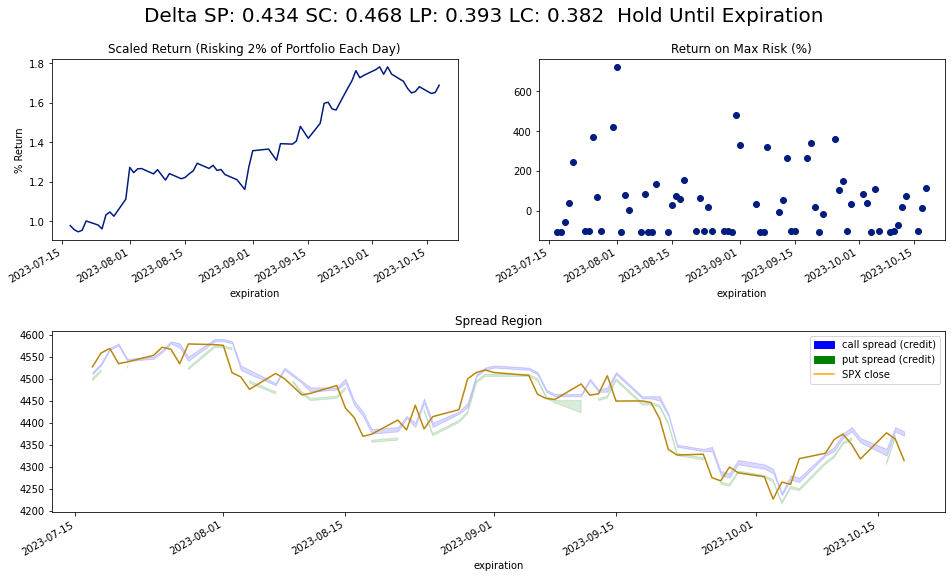

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-10-18,2023-10-19,0.434268,4305.0,0.415499,1385.0,0.46792,4320.0,0.45531,1605.0,0.381965,4330.0,0.370331,-1165.0,0.393434,4300.0,0.374499,-1205.0,4,620.0


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.13,short_calls=0.13)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-10-18,2023-10-19,0.13,4260.0,0.128607,312.5,0.13,4365.0,0.128272,280.0,2,592.5


Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
*****  BACKTEST RESULTS  ****
Cumulative Return                                 4.712
Max Drawdown                                     -1.284
Mean Net Max Loss                              1560.672
Max Net Max Loss                                19805.0
Mean Return on Max Risk                           0.035
Std Dev of Return on Max Risk                     0.328
Risk Adj Cumulative Return On Scaled Max Risk    14.366
Trading Days                                         67
Wins                                                 56
Losses                                               11
Breakeven                                             0
Win/Loss Ratio                                   83.582
Mean Win                                          205.0
Mean Loss                                       

{'Cumulative Return': 4.712,
 'Max Drawdown': -1.284,
 'Mean Net Max Loss': 1560.672,
 'Max Net Max Loss': 19805.0,
 'Mean Return on Max Risk': 0.035,
 'Std Dev of Return on Max Risk': 0.328,
 'Risk Adj Cumulative Return On Scaled Max Risk': 14.366,
 'Trading Days': 67,
 'Wins': 56,
 'Losses': 11,
 'Breakeven': 0,
 'Win/Loss Ratio': 83.582,
 'Mean Win': 205.0,
 'Mean Loss': -791.0,
 'Mean Net Trans': 41.478,
 'Std Dev of Net Trans': 424.412,
 'Max Loss': -1328.5,
 'Max Win': 261.5}

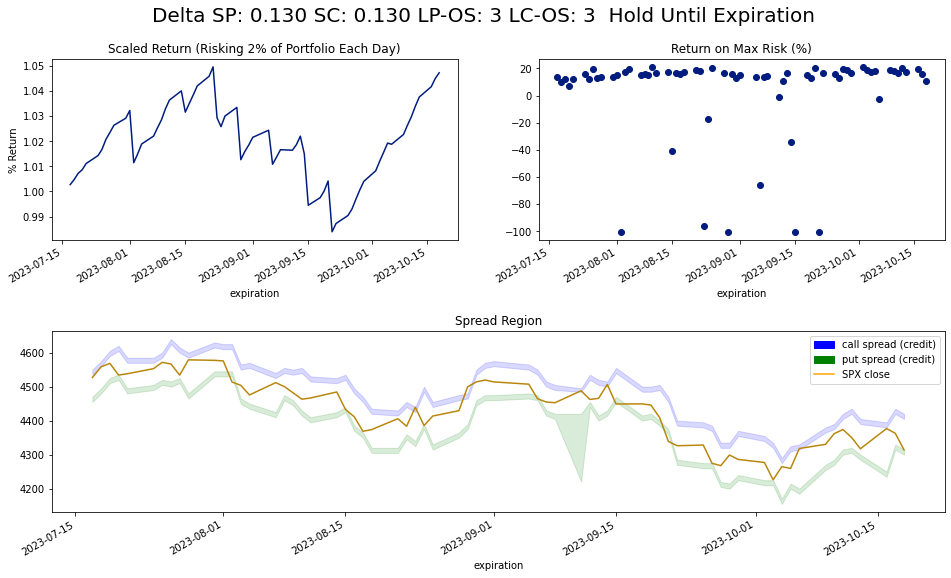

In [15]:
# test the new stuff
purchase_time = '15:45:00'
dos = DeltaAndOffsetOptionSelector(short_puts=0.13, short_calls=0.13, long_put_offsets=3, long_call_offsets=3)
# dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.fix_implausible_trades = True
strat.fix_threshold = 20
strat.evaluate(df)

In [16]:
best_average = 0
best_ma = 0

for i in range(1,25):
    day_change = i

    df_closing_prices = pd.DataFrame(df[df['quote_time']=='16:00:00'].groupby('quote_date')['price'].mean())
    df_closing_prices['x_day_average'] =  df_closing_prices['price'].pct_change(day_change)
    df_closing_prices['tomorrow_change'] = df_closing_prices['price'].shift(-1) - df_closing_prices['price']
    df_closing_prices.dropna(inplace=True)

    df_cp = df_closing_prices

    average_less_zero = df_cp[(df_cp['x_day_average']<0.00)].shape[0]
    average_greater_zero = df_cp[(df_cp['x_day_average']>0.00)].shape[0]
    average_and_tomorrow_less_zero = df_cp[(df_cp['x_day_average']<0.00)&(df_cp['tomorrow_change']<0.00)].shape[0]
    average_and_tomorrow_greater_zero = df_cp[(df_cp['x_day_average']>0.00)&(df_cp['tomorrow_change']>0.00)].shape[0]

    accuracy_less = average_and_tomorrow_less_zero / average_less_zero
    accuracy_greater = average_and_tomorrow_greater_zero / average_greater_zero
    
    if (accuracy_less + accuracy_greater) > best_average:
        best_average = accuracy_less + accuracy_greater
        best_ma = i

    print(f"For a {day_change} day moving average. Negative moves were {accuracy_less*100.}% accurate. Positive moves were : {accuracy_greater*100}% accurate")
print(f"The best overall predictive window : {i} days")

For a 1 day moving average. Negative moves were 58.333333333333336% accurate. Positive moves were : 46.666666666666664% accurate
For a 2 day moving average. Negative moves were 54.285714285714285% accurate. Positive moves were : 40.0% accurate
For a 3 day moving average. Negative moves were 51.42857142857142% accurate. Positive moves were : 34.48275862068966% accurate
For a 4 day moving average. Negative moves were 57.89473684210527% accurate. Positive moves were : 44.0% accurate
For a 5 day moving average. Negative moves were 60.526315789473685% accurate. Positive moves were : 45.83333333333333% accurate
For a 6 day moving average. Negative moves were 55.55555555555556% accurate. Positive moves were : 36.0% accurate
For a 7 day moving average. Negative moves were 57.89473684210527% accurate. Positive moves were : 36.36363636363637% accurate
For a 8 day moving average. Negative moves were 59.45945945945946% accurate. Positive moves were : 40.909090909090914% accurate
For a 9 day moving

In [17]:
print(f"The best overall predictive window : {i} days")

The best overall predictive window : 24 days


In [18]:
class DualOptionSelectorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, dte, trade_time, bear_option_selector, bull_option_selector, df_trend):
        self.dte = dte
        self.trade_time = trade_time
        self.bear_option_selector = bear_option_selector
        self.bull_option_selector = bull_option_selector
        self.df_trend = df_trend
        super().__init__()
    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        bullish_days = self.df_trend[(self.df_trend['x_day_average']>0.00)].reset_index()['quote_date']
        bearish_days = self.df_trend[(self.df_trend['x_day_average']<0.00)].reset_index()['quote_date']
        
        df_trades_bullish = df_trades[df_trades['trade_date'].isin(bullish_days)].copy()
#         print(f"bullish rows : {df_trades_bullish.shape[0]}")
        df_trades_bearish = df_trades[df_trades['trade_date'].isin(bearish_days)].copy()
#         print(f"bearish rows : {df_trades_bearish.shape[0]}")
        
        df_data = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        
        try:
            df_trades_bullish = self.bull_option_selector.populateTrades(df_data, df_trades_bullish, self.get_contract_strike)
#             print(f"Populated {df_trades_bullish.shape[0]} bullish trades")
            df_trades_bearish = self.bear_option_selector.populateTrades(df_data, df_trades_bearish, self.get_contract_strike)
#             print(f"Populated {df_trades_bearish.shape[0]} bearish trades")
        except ValueError as ve:
            print(f"Value error when populating trades for : {str(self)}. Were no trades found?")
            
        df_trades = pd.concat([df_trades_bullish,df_trades_bearish])
#         print(f"concatenated df_trades {df_trades.shape[0]} rows")
        df_trades.sort_values(by=['trade_date'], inplace=True)
        
        return df_trades
    
    def __str__(self):
        return str(self.bear_option_selector) + str(self.bull_option_selector)

    def __repr__(self):
        return str(self.bear_option_selector) + str(self.bull_option_selector)

Dropped 0 records because they had no trades on that day. They are available in df_trades_dropped
Fixing 0 trades. They are listed in the df_trades_unrealistic dataframe of the strategy object.
*****  BACKTEST RESULTS  ****
Cumulative Return                                19.503
Max Drawdown                                     -1.301
Mean Net Max Loss                               269.762
Max Net Max Loss                                  835.0
Mean Return on Max Risk                           0.151
Std Dev of Return on Max Risk                     0.962
Risk Adj Cumulative Return On Scaled Max Risk    20.273
Trading Days                                         63
Wins                                                 37
Losses                                               26
Breakeven                                             0
Win/Loss Ratio                                    58.73
Mean Win                                        227.189
Mean Loss                                      -

{'Cumulative Return': 19.503,
 'Max Drawdown': -1.301,
 'Mean Net Max Loss': 269.762,
 'Max Net Max Loss': 835.0,
 'Mean Return on Max Risk': 0.151,
 'Std Dev of Return on Max Risk': 0.962,
 'Risk Adj Cumulative Return On Scaled Max Risk': 20.273,
 'Trading Days': 63,
 'Wins': 37,
 'Losses': 26,
 'Breakeven': 0,
 'Win/Loss Ratio': 58.73,
 'Mean Win': 227.189,
 'Mean Loss': -256.577,
 'Mean Net Trans': 27.54,
 'Std Dev of Net Trans': 246.722,
 'Max Loss': -338.0,
 'Max Win': 302.0}

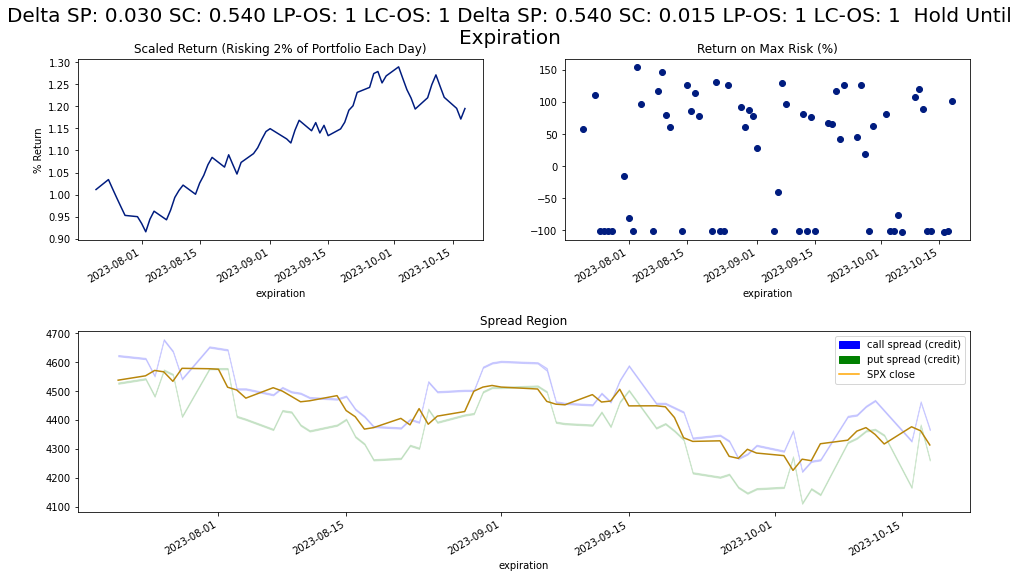

In [19]:
day_change = 4
df_closing_prices = pd.DataFrame(df[df['quote_time']=='16:00:00'].groupby('quote_date')['price'].mean())
df_closing_prices['x_day_average'] =  df_closing_prices['price'].pct_change(day_change)
df_closing_prices['tomorrow_change'] = df_closing_prices['price'].shift(-1) - df_closing_prices['price']
df_closing_prices.dropna(inplace=True)
df_cp = df_closing_prices


# test the new stuff
purchase_time = '15:45:00'
# dos = DeltaAndOffsetOptionSelector(short_puts=0.13, short_calls=0.13, long_put_offsets=3, long_call_offsets=3)
bear_dos = DeltaAndOffsetOptionSelector(short_calls=0.54,  long_call_offsets=1, short_puts=0.03,  long_put_offsets=1 )
bull_dos = DeltaAndOffsetOptionSelector(short_puts=0.54,  long_put_offsets=1, short_calls=0.015,  long_call_offsets=1 )
# dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
ent_pol=DualOptionSelectorStaticEntryPolicy(1, purchase_time, bear_dos, bull_dos, df_cp)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.fix_implausible_trades = True
strat.fix_threshold = 20
strat.evaluate(df)

Text(0, 0.5, '% Return')

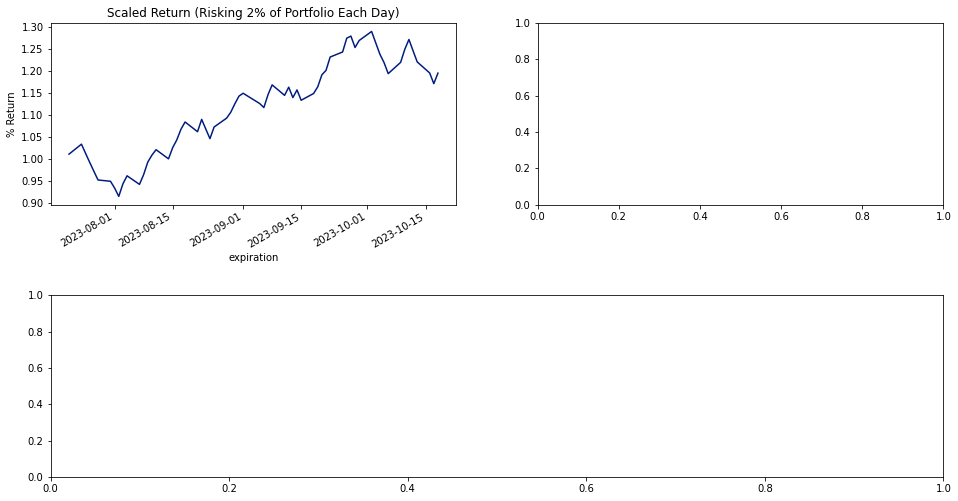

In [20]:
df_trade_plot = strat.df_trades.copy()


fig = plt.figure(figsize=(16,9))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

fig.subplots_adjust(top=0.9)
plt.subplots_adjust(hspace=0.5)


df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['scaled_return_on_max_risk'].cumprod()
df_trade_plot.plot(ax=ax1, )
ax1.set_title("Scaled Return (Risking 2% of Portfolio Each Day)")
ax1.set_ylabel('% Return')